In [1]:
import torch
import matplotlib.pyplot as plt
import os
import struct

from transformers import GPT2LMHeadModel
from transformers import AutoTokenizer
from transformers import LlamaForCausalLM
from transformers import T5ForConditionalGeneration

In [2]:
from enum import Enum

'''FP16_____________________________________________
|      |                    |                      |
|  s   |    exponential     |       mantissa       |
|______|____________________|_____________________ |
|  2   | 3-7                |   8-17               |
'''
'''BF16_____________________________________________
|      |                    |                      |
|  s   |    exponential     |       mantissa       |
|______|____________________|_____________________ |
|  2   | 3-10               |   11-17              |
'''

def compress(tensor, dim, base=None):
    import copy
    tensor = copy.deepcopy(tensor)
    assert base is not None
    if dim == 1:    # compress_method == col and pattern == row_wise
        tensor = tensor.T       # (512, 2048) -> (2048, 512) if pattrn == row_wise
    dim0, dim1 = tensor.shape   # (512, 2048) if pattern == col_wise else (2028, 512)
    if isinstance(base, int):
        for i in range(dim0):
            if i == base:
                continue
            tensor[i] = tensor[i] - tensor[base]
    elif isinstance(base, torch.Tensor):
        assert base.shape[0] == dim1, f"base.shape = {base.shape}, dim1 = {dim1}"
        for i in range(dim0):
            tensor[i] = tensor[i] - base    # base=512 if pattern == row_wise and compress_method == col else 2048
    return tensor.abs().T if dim == 1 else tensor.abs()

class CM(Enum):
    ROW_COMPRESS = lambda tensor, base=None: compress(tensor, 0, base)
    COL_COMPRESS = lambda tensor, base=None: compress(tensor, 1, base)
    SUBTLE = lambda tensor, base=None: (compress(tensor, 0, base), compress(tensor, 1, base))

In [3]:
def close(tensor, row_m_var, col_m_var)->bool:
    var_mean = torch.var(tensor.to(torch.float16))/tensor.numel()
    if torch.abs(row_m_var - col_m_var) < var_mean:
        return True
    else:
        return False

def get_pattern(tensor):
    col_m_var = torch.var(tensor.to(torch.float16), dim=0).mean()
    row_m_var = torch.var(tensor.to(torch.float16), dim=1).mean()

    if close(tensor, row_m_var, col_m_var):
        pattern = "CONFUSION"
        compress_method = CM.SUBTLE
    elif row_m_var < col_m_var:
        pattern = "ROW_WISE"
        compress_method = CM.COL_COMPRESS
    elif row_m_var > col_m_var:
        pattern = "COL_WISE"
        compress_method = CM.ROW_COMPRESS
    return pattern, compress_method

In [10]:
class Exponent:
    models_hub = {
        "gpt2": {
            "path": "/home/styaeng/project/delta-compress/pretrained_model/gpt2",
            "handler": GPT2LMHeadModel.from_pretrained
        },
        "llama2": {
            "path": "/home/styaeng/project/delta-compress/pretrained_model/llama2",
            "handler": LlamaForCausalLM.from_pretrained
        },
        "t5": {
            "path": "/home/styaeng/project/delta-compress/pretrained_model/t5",
            "handler": T5ForConditionalGeneration.from_pretrained
        }
    }
    def __init__(self, model_name, nbits, dtype=torch.float16):

        self.model_name = model_name
        self.exponent = None
        self.model = self._load_model(model_name)
        self.model = self.model.to(dtype)
        self.nbits = nbits
    
    def _load_model(self, model_name):
        path = Exponent.models_hub[model_name]['path']
        hlr = Exponent.models_hub[model_name]['handler']
        return hlr(path)
    
    def _pattern(self, tensor):
        return get_pattern(tensor)
    
    def get_exponent(self):
        if self.exponent is not None:
            print("self.exponent has already existed")
            return
        self.exponent = {}
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            # assert param.dtype is torch.float16
            if param.ndim == 2:
                r, c = param.shape
                tensor_data = list(
                    map(lambda x: int(
                            "{}".format(
                                    bin(
                                        int.from_bytes(
                                        struct.pack('>e', x), byteorder='big'
                                        )
                                    )[3: 3+self.nbits]      # torch.float16 [3: 8] torch.bfloat16[3: 11]
                                ), 
                                base=2
                        ),
                        param.abs().neg().reshape(-1).tolist()
                    )
                )
                tensor = torch.tensor(tensor_data, dtype=torch.int8).reshape(r, c)
                self.exponent[name] = {}
                self.exponent[name]['tensor'] = tensor
                self.exponent[name]['pattern'], self.exponent[name]['compressmethod'] = self._pattern(tensor)
    
    def compress(self):
        self.decompressed = {}
        for name, val in self.exponent.item():
            self.decompressed[name] = val['compressmethod'](val['tensor'])

# hf2b = lambda x: bin(int.from_bytes(struct.pack('>e', x), byteorder='big'))

In [11]:
t5_exponent_2bits = Exponent('t5', nbits=2, dtype=torch.bfloat16)
t5_exponent_2bits.get_exponent()

t5_exponent_3bits = Exponent('t5', nbits=3)
t5_exponent_3bits.get_exponent()

In [15]:
# n = 2
# KB = 1024

# # value_list = torch.zeros((2 **n, ))
# for k, v in t5_exponent_2bits.exponent.items():
#     if "bias" in k:
#         continue
#     val_count = torch.bincount(v['tensor'].reshape(-1))
#     page_count = ((val_count * (16 - n) + (4 * KB - 1)) // (4 * KB)).sum()
#     original_page_count = (v['tensor'].numel() * 16 + (4 * KB - 1)) // (4 * KB)
#     print(f"{k}\t\toriginal_page_num = {original_page_count}\tpresent_page_num = {page_count}\t compress_rate = {(original_page_count - page_count) / original_page_count * 100:.3f} %")

In [ ]:
# n = 3
# KB = 1024

# # value_list = torch.zeros((2 **n, ))
# for k, v in t5_exponent_3bits.exponent.items():
#     if "bias" in k:
#         continue
#     val_count = torch.bincount(v['tensor'].reshape(-1))
#     page_count = ((val_count * (16 - n) + (4 * KB - 1)) // (4 * KB)).sum()
#     original_page_count = (v['tensor'].numel() * 16 + (4 * KB - 1)) // (4 * KB)
#     print(f"{k}\t\toriginal_page_num = {original_page_count}\tpresent_page_num = {page_count}\t compress_rate = {(original_page_count - page_count) / original_page_count * 100:.3f} %")

In [8]:
block = [f"encoder.block.{i}.layer.0.SelfAttention.q.weight" for i in range(5)] + \
    [f"encoder.block.{i}.layer.1.DenseReluDense.wo.weight" for i in range(5)] + \
        [f"decoder.block.{i}.layer.0.SelfAttention.q.weight" for i in range(5)] + \
            [f"decoder.block.{i}.layer.1.EncDecAttention.q.weight" for i in range(5)] + \
                    [f"decoder.block.{i}.layer.2.DenseReluDense.wo.weight" for i in range(5)]

print(len(block))

25


In [ ]:
for idx, blk in enumerate(block):
    print(f"{block[idx]} -----> {t5_exponent_2bits.exponent[blk]['pattern']}")

In [13]:
value = 1
row, col = t.shape
for idx, blk in enumerate(block):
    t = t5_exponent_2bits.exponent[blk]['tensor']
    count_in_row = torch.count_nonzero(t == value, dim=1)
    count_in_col = torch.count_nonzero(t == value, dim=0)
    deter_row_pattern = torch.count_nonzero(count_in_row > 0.90*col).item() * col
    deter_col_pattern = torch.count_nonzero(count_in_col > 0.90*row).item() * row

    if deter_row_pattern > deter_col_pattern:
        print(f"{block[idx]} -----> ROW_WISE")
    elif deter_row_pattern < deter_col_pattern:
        print(f"{block[idx]} -----> COL_WISE")
    else:
        print(f"{block[idx]} -----> CONFUSION")

encoder.block.0.layer.0.SelfAttention.q.weight -----> COL_WISE
encoder.block.1.layer.0.SelfAttention.q.weight -----> COL_WISE
encoder.block.2.layer.0.SelfAttention.q.weight -----> COL_WISE
encoder.block.3.layer.0.SelfAttention.q.weight -----> COL_WISE
encoder.block.4.layer.0.SelfAttention.q.weight -----> COL_WISE
encoder.block.0.layer.1.DenseReluDense.wo.weight -----> ROW_WISE
encoder.block.1.layer.1.DenseReluDense.wo.weight -----> ROW_WISE
encoder.block.2.layer.1.DenseReluDense.wo.weight -----> ROW_WISE
encoder.block.3.layer.1.DenseReluDense.wo.weight -----> ROW_WISE
encoder.block.4.layer.1.DenseReluDense.wo.weight -----> ROW_WISE
decoder.block.0.layer.0.SelfAttention.q.weight -----> COL_WISE
decoder.block.1.layer.0.SelfAttention.q.weight -----> COL_WISE
decoder.block.2.layer.0.SelfAttention.q.weight -----> COL_WISE
decoder.block.3.layer.0.SelfAttention.q.weight -----> COL_WISE
decoder.block.4.layer.0.SelfAttention.q.weight -----> COL_WISE
decoder.block.0.layer.1.EncDecAttention.q.wei

In [29]:
tensor_pattern = []
for k, v in t5_exponent_2bits.exponent.items():
    # tensor_self_pattern["name"] = k
    tensor_self_pattern = {
        "name": "",
        "compress": {
            ##### value = 0|1|2|[3] #####
        },
        "compress_num":{
            ##### value = 0|1|2|[3] #####
        },
        "no_compress_num":{
            ##### value = 0|1|2|[3] #####
        }
    }
    tensor_self_pattern['name'] = k
    row, col = v['tensor'].shape
    t = v['tensor']
    for value in range(0b100):
        # tensor_self_pattern["pattern"][value]
        count_in_row = torch.count_nonzero(t == value, dim=1)
        count_in_col = torch.count_nonzero(t == value, dim=0)
        deter_row_pattern = torch.count_nonzero(count_in_row > 0.90*col).item() * col
        deter_col_pattern = torch.count_nonzero(count_in_col > 0.90*row).item() * row

        if deter_row_pattern > deter_col_pattern:
            tensor_self_pattern['compress'][value] = "ROW_COMPRESS"
            tensor_self_pattern['compress_num'][value] = count_in_row
            # tensor_self_pattern['no_compress_num'][value] = count_in_col
            #print(f"{block[idx]} -----> ROW_WISE")
        elif deter_row_pattern < deter_col_pattern:
            tensor_self_pattern['compress'][value] = "COL_COMPRESS"
            tensor_self_pattern['compress_num'][value] = count_in_col
            # tensor_self_pattern['no_compress_num'][value] = count_in_row
            # print(f"{block[idx]} -----> COL_WISE")
        else:
            tensor_self_pattern['compress'][value] = "CONFUSION"
            tensor_self_pattern['compress_num'][value] = count_in_row
            # tensor_self_pattern['no_compress_num'][value] = count_in_col
            # print(f"{block[idx]} -----> CONFUSION")
    # print("temp "+tensor_self_pattern['name'])
    tensor_pattern.append(tensor_self_pattern)


In [30]:
print(tensor_pattern[0]['compress_num'][0])
print(tensor_pattern[0]['compress_num'][1])
print(tensor_pattern[0]['compress_num'][2])
print(tensor_pattern[0]['compress_num'][3])

tensor([1, 0, 0,  ..., 0, 0, 0])
tensor([297,  59,  40,  ...,  42,  41,  43])
tensor([213, 453, 472,  ..., 470, 471, 469])
tensor([1, 0, 0,  ..., 0, 0, 0])


In [23]:
t5_exponent_2bits.exponent[tensor_pattern[0]['name']]['tensor'].shape

torch.Size([32128, 512])

In [28]:
print(tensor_pattern[0]['compress_num'][3].shape)

torch.Size([32128])


In [33]:
# for name, elem in t5_exponent_2bits.exponent.items():
#     print(name)
compress_info = []
for idx in range(len(tensor_pattern)):
    tensor_compress_info = {
        "name":"",
        "shape":"",
        0:{},
        1:{},
        2:{},
        3:{}
    }
    name = tensor_pattern[idx]['name']
    tensor_compress_info['name'] = name
    tensor_compress_info['shape'] = t5_exponent_2bits.exponent[name].shape
    # compressed_count = []
    # uncompressed_count = []
    max_count = []
    for val in range(0b11+1):
        compress = tensor_pattern[idx][val]['compress']
        if compress == "ROW_COMPRESS":
            tensor_compress_info[val]['compress'] = "ROW_COMPRESS"
        elif compress == "COL_COMPRESS":
            tensor_compress_info[val]['compress'] = "COL_COMPRESS"
        elif compress == "CONFUSION":
            tensor_compress_info[val]['compress'] = "CONFUSION"
            # pass


shared.weight
encoder.block.0.layer.0.SelfAttention.q.weight
encoder.block.0.layer.0.SelfAttention.k.weight
encoder.block.0.layer.0.SelfAttention.v.weight
encoder.block.0.layer.0.SelfAttention.o.weight
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight
encoder.block.0.layer.1.DenseReluDense.wi.weight
encoder.block.0.layer.1.DenseReluDense.wo.weight
encoder.block.1.layer.0.SelfAttention.q.weight
encoder.block.1.layer.0.SelfAttention.k.weight
encoder.block.1.layer.0.SelfAttention.v.weight
encoder.block.1.layer.0.SelfAttention.o.weight
encoder.block.1.layer.1.DenseReluDense.wi.weight
encoder.block.1.layer.1.DenseReluDense.wo.weight
encoder.block.2.layer.0.SelfAttention.q.weight
encoder.block.2.layer.0.SelfAttention.k.weight
encoder.block.2.layer.0.SelfAttention.v.weight
encoder.block.2.layer.0.SelfAttention.o.weight
encoder.block.2.layer.1.DenseReluDense.wi.weight
encoder.block.2.layer.1.DenseReluDense.wo.weight
encoder.block.3.layer.0.SelfAttention.q.weight
encoder.bloc

In [11]:
n = 2
KB = 1024

# value_list = torch.zeros((2 **n, ))
for k, v in t5_exponent_2bits.exponent.items():
    if "bias" in k:
        continue
    val_count = torch.bincount(v['tensor'].reshape(-1))
    page_count = ((val_count * (16 - n) + (4 * KB - 1)) // (4 * KB)).sum()
    original_page_count = (v['tensor'].numel() * 16 + (4 * KB - 1)) // (4 * KB)
    print(f"{k}\t\toriginal_page_num = {original_page_count}\tpresent_page_num = {page_count}\t compress_rate = {(original_page_count - page_count) / original_page_count * 100:.3f} %")

shared.weight		original_page_num = 64256	present_page_num = 56226	 compress_rate = 12.497 %
encoder.block.0.layer.0.SelfAttention.q.weight		original_page_num = 1024	present_page_num = 897	 compress_rate = 12.402 %
encoder.block.0.layer.0.SelfAttention.k.weight		original_page_num = 1024	present_page_num = 898	 compress_rate = 12.305 %
encoder.block.0.layer.0.SelfAttention.v.weight		original_page_num = 1024	present_page_num = 898	 compress_rate = 12.305 %
encoder.block.0.layer.0.SelfAttention.o.weight		original_page_num = 1024	present_page_num = 898	 compress_rate = 12.305 %
encoder.block.0.layer.1.DenseReluDense.wi.weight		original_page_num = 4096	present_page_num = 3586	 compress_rate = 12.451 %
encoder.block.0.layer.1.DenseReluDense.wo.weight		original_page_num = 4096	present_page_num = 3586	 compress_rate = 12.451 %
encoder.block.1.layer.0.SelfAttention.q.weight		original_page_num = 1024	present_page_num = 897	 compress_rate = 12.402 %
encoder.block.1.layer.0.SelfAttention.k.weight		

ROW_WISE


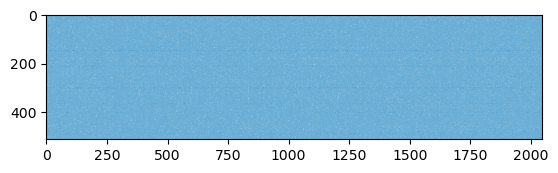

In [42]:
name = 'decoder.block.4.layer.2.DenseReluDense.wo.weight'
t = t5_exponent_2bits.exponent[name]['tensor']
cf = t5_exponent_2bits.exponent[name]['compressmethod']
p = t5_exponent_2bits.exponent[name]['pattern']
print(p)
plt.imshow(t, cmap='Blues')
plt.show()

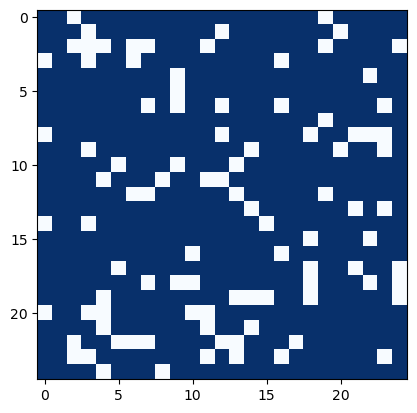

In [13]:
plt.imshow(t[:25, :25], cmap="Blues")

In [14]:
'''
1. 统计有多少个行超过了一个阈值，哪些个列超过了超过了一个阈值
2. 如果超过了这个阈值，就证明是可以压缩的，那么就要记下来一个行号或者列号，这就造成了一定的压缩开销
3. 对于哪些没有超过一个阈值的行或者列，那么就把每一个元素的位置记下来
4. 统计一下整个模型的压缩率是多少，压缩开销是多少
'''


"""
需要两个索引列表(row/col)来记下来异常值的位置和值本身，对于那些超过了一个阈值的，直接记录一个行号或者列号以及其值就好了。
"""

'\n需要两个索引列表(row/col)来记下来异常值的位置和值本身，对于那些超过了一个阈值的，直接记录一个行号或者列号以及其值就好了。\n'

In [15]:
s = [i for i in range(512)]
S = ""
for i in s:
    S += f"Row {i}\t"

print(S)
tt = torch.count_nonzero(t == 1, dim=1)
for i in range(512):
    print(tt[i].item(), end="\t")

Row 0	Row 1	Row 2	Row 3	Row 4	Row 5	Row 6	Row 7	Row 8	Row 9	Row 10	Row 11	Row 12	Row 13	Row 14	Row 15	Row 16	Row 17	Row 18	Row 19	Row 20	Row 21	Row 22	Row 23	Row 24	Row 25	Row 26	Row 27	Row 28	Row 29	Row 30	Row 31	Row 32	Row 33	Row 34	Row 35	Row 36	Row 37	Row 38	Row 39	Row 40	Row 41	Row 42	Row 43	Row 44	Row 45	Row 46	Row 47	Row 48	Row 49	Row 50	Row 51	Row 52	Row 53	Row 54	Row 55	Row 56	Row 57	Row 58	Row 59	Row 60	Row 61	Row 62	Row 63	Row 64	Row 65	Row 66	Row 67	Row 68	Row 69	Row 70	Row 71	Row 72	Row 73	Row 74	Row 75	Row 76	Row 77	Row 78	Row 79	Row 80	Row 81	Row 82	Row 83	Row 84	Row 85	Row 86	Row 87	Row 88	Row 89	Row 90	Row 91	Row 92	Row 93	Row 94	Row 95	Row 96	Row 97	Row 98	Row 99	Row 100	Row 101	Row 102	Row 103	Row 104	Row 105	Row 106	Row 107	Row 108	Row 109	Row 110	Row 111	Row 112	Row 113	Row 114	Row 115	Row 116	Row 117	Row 118	Row 119	Row 120	Row 121	Row 122	Row 123	Row 124	Row 125	Row 126	Row 127	Row 128	Row 129	Row 130	Row 131	Row 132	Row 133	Row 134	Row 135	Row 136	Row 137	Row 13

In [16]:
'''
I need to create a new .csv file like this:
EQUAL particular value
TensorName, Row0, ..., Row511
TensorName, Col0, ..., Row511s

I need a hierarchical dictionary first to store the information about the csv file i will write.
    * Key --- TensorName
        * value --- particular values
            * Row index
            * Col index
'''

# dict_row_col = {}

'\nI need to create a new csv file like this:\nEQUAL particular value\nTensorName, Row0, ..., Row511\nTensorName, Col0, ..., Row511s\n\nI need a hierarchical dictionary first to store the information about the csv file i will write.\n    * Key --- TensorName\n        * value --- particular values\n            * Row index\n            * Col index\n'

In [17]:
row, col = t.shape
row_range = torch.arange(row)
col_range = torch.arange(col)

cnt_info = {"name":"", "pattern": [],
            "value":[],
            "rowidx":[],
            "colidx": []}
cnt_info["name"] = name
for value in range(0b100):
    count_in_row = torch.count_nonzero(t == value, dim=1)
    count_in_col = torch.count_nonzero(t == value, dim=0)
    deter_row_pattern = torch.count_nonzero(count_in_row > col) / row
    deter_col_pattern = torch.count_nonzero(count_in_col > row) / col
    if deter_row_pattern > deter_col_pattern:     # there is a mistake
        cnt_info['pattern'].append("row")
    else:
        cnt_info['pattern'].append('col')
    cnt_info['value'].append(value)

    tmp_row = []
    tmp_col = []
    for row_idx, cnt in enumerate(count_in_row):
        tmp_row.append([row_idx])
        if cnt < row // 2:
            tmp_col.append(col_range[t[row_idx] == value].tolist())
    cnt_info['rowidx'].append(tmp_row)
    cnt_info['colidx'].append(tmp_col)

In [56]:
row, col = t.shape

In [ ]:
'''
cnt_info结构:
    1. cnt_info['rowidx']是一个长度与value_list相同的数组;
    2. cnt_info['rowidx'][value]的长度与row的长度相同
    3. cnt_info['rowidx'][value][row_idx]的每个元素的长度为1

    1. cnt_info['colidx']是一个长度和value_list相同的数组;
    2. cnt_info['colidx'][value]的每个elem的长度不定, 代表该数值

'''

In [102]:
len(cnt_info['colidx'][0])

512

In [68]:
t[1,20]

tensor(0, dtype=torch.int8)

In [ ]:
# torch.count_nonzero(t == 1, dim=1)

In [ ]:
t5_exponent_2bits.exponent['shared.weight'].keys()

dict_keys(['tensor', 'pattern', 'compressmethod'])

In [14]:
dict_row_col = {}

dict_row_col['2bit'] = {}
for k, v in t5_exponent_2bits.exponent.items():
    assert v['tensor'].ndim == 2
    dict_row_col['2bit'][k] = {}
    for pv in range(0b11):
        dict_row_col['2bit'][k][f"{pv:#06b}"] = {}
        tmp_row = torch.count_nonzero(v['tensor'] == pv, dim=1)
        tmp_col = torch.count_nonzero(v['tensor'] == pv, dim=0)
        assert tmp_row.ndim == 1 and tmp_col.ndim == 1

        dict_row_col['2bit'][k][f"{pv:#06b}"]['Row'] = {}
        dict_row_col['2bit'][k][f"{pv:#06b}"]['Col'] = {}
        for ri in range(len(tmp_row)):
            # assert tmp_row[ri] > v['tensor'].shape[1] 
            dict_row_col['2bit'][k][f"{pv:#06b}"]['Row'][f'Row_{ri}'] = tmp_row[ri].item()
        for ci in range(len(tmp_col)):
            # assert tmp_row[ri] > v['tensor'].shape[0] 
            dict_row_col['2bit'][k][f"{pv:#06b}"]['Col'][f"Col_{ci}"] = tmp_col[ci].item()

dict_row_col['3bit'] = {}
for k, v in t5_exponent_3bits.exponent.items():
    assert v['tensor'].ndim == 2
    dict_row_col['3bit'][k] = {}
    for pv in range(0b111):
        dict_row_col['3bit'][k][f"{pv:#06b}"] = {}
        tmp_row = torch.count_nonzero(v['tensor'] == pv, dim=1)
        tmp_col = torch.count_nonzero(v['tensor'] == pv, dim=0)
        assert tmp_row.ndim == 1 and tmp_col.ndim == 1

        dict_row_col['3bit'][k][f"{pv:#06b}"]['Row'] = {}
        dict_row_col['3bit'][k][f"{pv:#06b}"]['Col'] = {}
        for ri in range(len(tmp_row)):
            # assert tmp_row[ri] > v['tensor'].shape[1]
            dict_row_col['3bit'][k][f"{pv:#06b}"]['Row'][f'Row_{ri}'] = tmp_row[ri].item()
        for ci in range(len(tmp_col)):
            # assert tmp_row[ri] > v['tensor'].shape[0]
            dict_row_col['3bit'][k][f"{pv:#06b}"]['Col'][f"Col_{ci}"] = tmp_col[ci].item()

In [ ]:
"""
{
    "tensor": {
        "structured" : {
            "value": {
                "row": {
                    : -> rowidx;
                },
                "col": {
                    : -> colidx;
                },
            },
        },
        "unstructured": {
            "value": {
                "row": {
                    "colidx": []
                },
                "col": {
                    "rowidx": []
                },
            },
        },
    },
}
"""



'\n{\n    "tensor": {\n        "structured" : {\n            "value": {\n                "row": {\n                    : -> rowidx;\n                },\n                "col": {\n                    : -> colidx;\n                },\n            },\n        },\n        "unstructured": {\n            "value": {\n                "row": {\n                    "colidx": []\n                },\n                "col": {\n                    "rowidx": []\n                },\n            },\n        },\n    },\n}\n'

In [ ]:
compressed_tensor = {}
compressed_tensor[name] = {
    "structured": {
        "value": [],
        "row": [],
        "col": []
    },
    "unstructured": {
        "value": [],
        "row": [],
        "col": []
    }
}
tmp_count_info = dict_row_col["2bit"][name]
row, col = t.shape
row_idx_range = torch.arange(row)
col_idx_range = torch.arange(col)

for pv in range(0b11):
    ref_count_info = tmp_count_info[f"{pv:#06b}"]
    compressed_tensor[name]['unstructured']['value'].append(pv)
    compressed_tensor[name]['structured']['value'].append(pv)

    for r_or_c, v in ref_count_info.items():
        # tmp_row = []
        # tmp_col = []
        for idx, cnt in v.items():
            if r_or_c == 'Row':
                if cnt < row // 2:
                    # tmp_row.append([idx])
                    tensor_col = col_idx_range[t5_exponent_2bits.exponent[name]['tensor'][eval(idx.split('_')[-1])] == pv].tolist()
                    # tmp_col.append(tensor_col)
                    compressed_tensor[name]["unstructured"]['row'].append([idx])
                    compressed_tensor[name]['unstructured']['col'].append(tensor_col)
                    
                else:
                    # compressed_tensor[name]["structured"]['value'].append(pv)
                    compressed_tensor[name]["structured"]['row'].append([idx])
                    compressed_tensor[name]['structured']['col'].append([])

In [ ]:
# dict_row_col['2bit'] = {}
# for k, v in t5_exponent_2bits.exponent.items():
#     assert v['tensor'].ndim == 2
#     dict_row_col['2bit'][k] = {}
#     for pv in range(0b11):
#         dict_row_col['2bit'][k][f"{pv:#06b}"] = {}
#         tmp_row = torch.count_nonzero(v['tensor'] == pv, dim=1)
#         tmp_col = torch.count_nonzero(v['tensor'] == pv, dim=0)
#         assert tmp_row.ndim == 1 and tmp_col.ndim == 1

#         dict_row_col['2bit'][k][f"{pv:#06b}"]['Row'] = {}
#         dict_row_col['2bit'][k][f"{pv:#06b}"]['Col'] = {}
#         for ri in range(len(tmp_row)):
#             # assert tmp_row[ri] > v['tensor'].shape[1] 
#             dict_row_col['2bit'][k][f"{pv:#06b}"]['Row'][f'Row_{ri}'] = tmp_row[ri].item()
#         for ci in range(len(tmp_col)):
#             # assert tmp_row[ri] > v['tensor'].shape[0] 
#             dict_row_col['2bit'][k][f"{pv:#06b}"]['Col'][f"Col_{ci}"] = tmp_col[ci].item()


compressed_tensor = {}
for name, v in t5_exponent_2bits.exponent.items():
    compressed_tensor[name] = {
        "structured": {
            "value": [],
            "row": [],
            "col": []
        },
        "unstructured": {
            "value":[],
            "row": [],
            "col": []
        }
    }

    assert v['tensor'].ndim == 2
    row, col = v['tensor'].shape
    tmp_count_info = dict_row_col['2bit'][name]

    # tmp_row = []
    # tmp_col = []
    row_idx_range = torch.arange(row)
    col_idx_range = torch.arange(col)
    for pv in range(0b11):
        tmp_row = []
        tmp_col = []
        ref_count_info = tmp_count_info[f"{pv:#06b}"]
        for r_or_c, v in ref_count_info.items():
            for idx, cnt in v.items():
                if r_or_c == 'Row':
                    if cnt < row // 2:
                        compressed_tensor[name]['unstructured']['value'].append(pv)
                        tmp_row.append([idx])
                        tensor_col = col_idx_range[t5_exponent_2bits.exponent[name]['tensor'][eval(idx.split('_')[-1])] == pv].tolist()
                        tmp_col.append(tensor_col)
                        compressed_tensor[name]["unstructured"]['row'].append(tmp_row)
                        compressed_tensor[name]['unstructured']['col'].append(tmp_col)
                        
                    else:
                        compressed_tensor[name]["structured"]['value'].append(pv)
                        compressed_tensor[name]["structured"]['row'].append([idx])
                        compressed_tensor[name]['structured']['col'].append([])

                        



    

In [38]:
import json

with open("./dict_row_col.json", "w+") as f:
    json.dump(dict_row_col, f, indent='\t')

In [17]:
n = 3
KB = 1024

# value_list = torch.zeros((2 **n, ))
for k, v in t5_exponent_3bits.exponent.items():
    if "bias" in k:
        continue
    val_count = torch.bincount(v['tensor'].reshape(-1))
    page_count = ((val_count * (16 - n) + (4 * KB - 1)) // (4 * KB)).sum()
    original_page_count = (v['tensor'].numel() * 16 + (4 * KB - 1)) // (4 * KB)
    print(f"{k}\t\toriginal_page_num = {original_page_count}\tpresent_page_num = {page_count}\t compress_rate = {(original_page_count - page_count) / original_page_count * 100:.3f} %")

shared.weight		original_page_num = 64256	present_page_num = 52212	 compress_rate = 18.744 %
encoder.block.0.layer.0.SelfAttention.q.weight		original_page_num = 1024	present_page_num = 834	 compress_rate = 18.555 %
encoder.block.0.layer.0.SelfAttention.k.weight		original_page_num = 1024	present_page_num = 835	 compress_rate = 18.457 %
encoder.block.0.layer.0.SelfAttention.v.weight		original_page_num = 1024	present_page_num = 835	 compress_rate = 18.457 %
encoder.block.0.layer.0.SelfAttention.o.weight		original_page_num = 1024	present_page_num = 835	 compress_rate = 18.457 %
encoder.block.0.layer.1.DenseReluDense.wi.weight		original_page_num = 4096	present_page_num = 3331	 compress_rate = 18.677 %
encoder.block.0.layer.1.DenseReluDense.wo.weight		original_page_num = 4096	present_page_num = 3330	 compress_rate = 18.701 %
encoder.block.1.layer.0.SelfAttention.q.weight		original_page_num = 1024	present_page_num = 834	 compress_rate = 18.555 %
encoder.block.1.layer.0.SelfAttention.k.weight		

In [86]:
(value_list * (16 - n) + (4 * 1024) - 1) // (4 * 1024)

tensor([106., 791.,   0.,   0.])

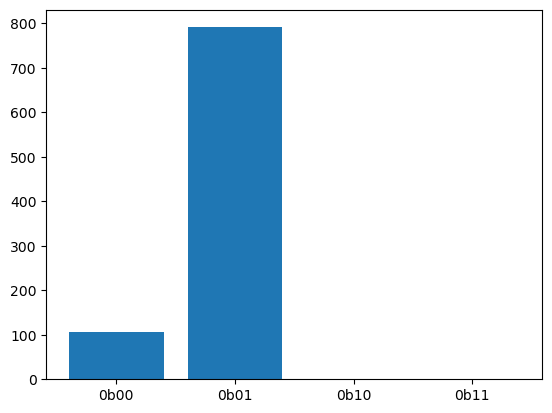

In [87]:
n = 2
value_list = torch.zeros(2**n, )
val_count = torch.bincount(t.reshape(-1))

value_list[:len(val_count)] = val_count
page_num = (value_list * (16 - n) + (4 * 1024) - 1) // (4 * 1024)

plt.bar(["{:#04b}".format(i) for i in range(2**n)], page_num)
plt.show()

In [97]:
ori_page_num = (t.numel() * 16 + 4096 - 1) // 4096
print(f"original_page_num = {ori_page_num}")
print(f"after compressed, page_name = {page_num.sum()}\ncompression rate = {page_num.sum() / ori_page_num}")

original_page_num = 1024
after compressed, page_name = 897.0
 compression rate = 0.8759765625


In [56]:
value_range = [i for i in range(0, 0b100000)]

m = 8
for i in range(len(value_range) // m):
    for j in range(m):
        print("{:#07b}".format(value_range[i + j*(len(value_range)) // m]), end="\t"*2)
    print()

def count_bin(tensor, mn):
    '''
    bn: how many bits are same from MSB to LSB
    '''
    assert 0 <= mn <= 5
    stride = 0b11111 ^ eval("0b"+'0'*mn+(5-mn)*'1')
    return stride
    # pass

0b00000		0b00100		0b01000		0b01100		0b10000		0b10100		0b11000		0b11100		
0b00001		0b00101		0b01001		0b01101		0b10001		0b10101		0b11001		0b11101		
0b00010		0b00110		0b01010		0b01110		0b10010		0b10110		0b11010		0b11110		
0b00011		0b00111		0b01011		0b01111		0b10011		0b10111		0b11011		0b11111		


In [57]:
p = 2
count_bin(None, p)

24

In [37]:
p = 2
torch.bincount((t & count_bin(None, p)).reshape(-1))

tensor([[ 9, 11,  7,  ...,  9, 10, 11],
        [10,  9, 10,  ..., 10, 10, 11],
        [10, 10,  7,  ..., 10,  9, 10],
        ...,
        [11,  8, 11,  ...,  7, 11, 10],
        [ 5,  9, 10,  ..., 11,  9,  5],
        [11,  2,  6,  ..., 10, 10, 10]], dtype=torch.int8)

In [34]:
torch.bincount((t & count_bin(None, p)).reshape(-1))

tensor([  1947,      0,      0,      0,  28875,      0,      0,      0, 219735,
             0,      0,      0,  11587])

In [109]:
for i in range(1, 6):
    print("{:#07b}".format(count_bin(None, i)))

0b10000
0b11000
0b11100
0b11110
0b11111


In [86]:
t

tensor([[ 9, 11,  7,  ...,  9, 10, 11],
        [10,  9, 10,  ..., 10, 10, 11],
        [10, 10,  7,  ..., 10,  9, 10],
        ...,
        [11,  8, 11,  ...,  7, 11, 10],
        [ 5,  9, 10,  ..., 11,  9,  5],
        [11,  2,  6,  ..., 10, 10, 10]], dtype=torch.int8)

In [11]:
def get_newblock(ct):
    maxlen = 0
    for vec in ct:
        if torch.bincount(vec).shape[0] > maxlen:
            maxlen = torch.bincount(vec).shape[0]
    # print(maxlen)

    new_block = torch.zeros((ct.shape[0], maxlen))

    for rowidx, vec in enumerate(ct):
        bincount = torch.bincount(vec)
        new_block[rowidx, :len(bincount)] = bincount

    new_block = new_block / new_block.sum(dim=1, keepdim=True)

    return new_block

def get_most(t, dim=0):
    if dim == 1:
        t = t.T     # (512, 2048) -> (2048, 512)
    base_vec = torch.zeros(t.shape[0])
    plt.imshow(0<=t<0b00100)

    for idx, vec in enumerate(t):
        bincount_vec = torch.bincount(vec)
        base_vec[idx] = bincount_vec.argmax()
    return base_vec

def get_median(t, dim=0):
    if dim == 0:
        t = t.T
    t_sorted = torch.sort(t, dim=0)[0]
    return t_sorted[t.shape[1]//2] if dim==0 else t_sorted[t.shape[0]//2]

In [12]:
'''
    Actually, we need to define a loss function to determine which base is the best.
        * We take the variances into account.
        * xxxxxxxxxxx
    Loss:
        f(x) = a * var(x, dim=0).sum() + b * var(x, dim=1).sum()    {a, b| a>0, b<0}
        The smaller, the better.

    In addition, how many bits will be used after compression should involve in consideration.
        Emmmmm...
        Let me think about it...
        zero is 1 bit
        one is 1 bit
        two is 2 bits
        three is 2 bits
        ...
        we take the 
        
'''

def loss(base, dim=0):
    if dim == 1:
        base = base.T
    output = 10 * torch.var(base, dim=0).sum() - \
                0.3*torch.var(base, dim=1).sum() - \
                2 * (base[:,:4].sum() / base.sum())
    return output

In [14]:
md = get_most(t, dim=1)
print(md.shape)
md = get_median(t, dim=1)
print(md.shape)

torch.Size([512])
torch.Size([512])


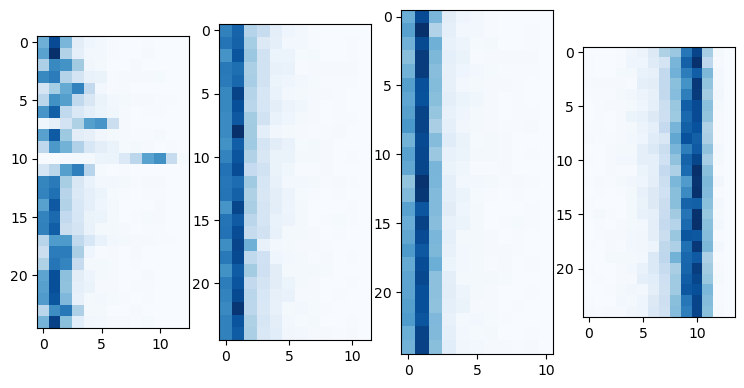

In [15]:
ct0 = cf(t, 0)
ct1 = cf(t, get_most(t, dim=0))
ct2 = cf(t, get_median(t, dim=0))

# new_block = get_newblock(ct)
'''
We have three base choices: the first row/column, the vector of the most frequent values, the median vector
'''

base1_blk = get_newblock(ct0)
base2_blk = get_newblock(ct1)
base3_blk = get_newblock(ct2)
fig, ax = plt.subplots(1, 4, figsize=(9, 15))
bare_base = get_newblock(t)

ax[0].imshow(base1_blk[25:50], cmap="Blues")
ax[1].imshow(base2_blk[25:50], cmap="Blues")
ax[2].imshow(base3_blk[25:50], cmap="Blues")
ax[3].imshow(bare_base[25:50], cmap="Blues")

plt.show()

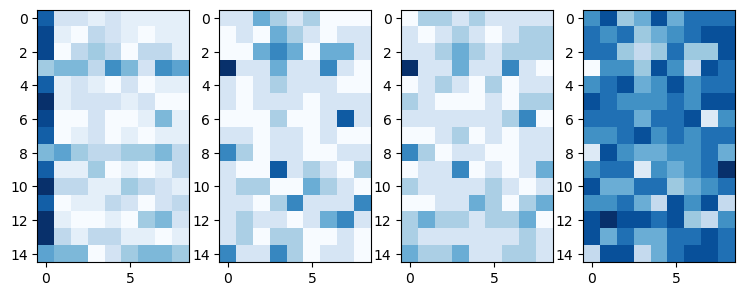

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(9, 15))
bare_base = get_newblock(t)

ax[0].imshow(ct0[:15, :9], cmap="Blues")
ax[1].imshow(ct1[:15, :9], cmap="Blues")
ax[2].imshow(ct2[:15, :9], cmap="Blues")
ax[3].imshow(t[:15, :9], cmap="Blues")

plt.show()

In [167]:
loss(base1_blk), loss(base2_blk), loss(base3_blk)

(tensor(-3.3700), tensor(-4.4075), tensor(-3.9265))

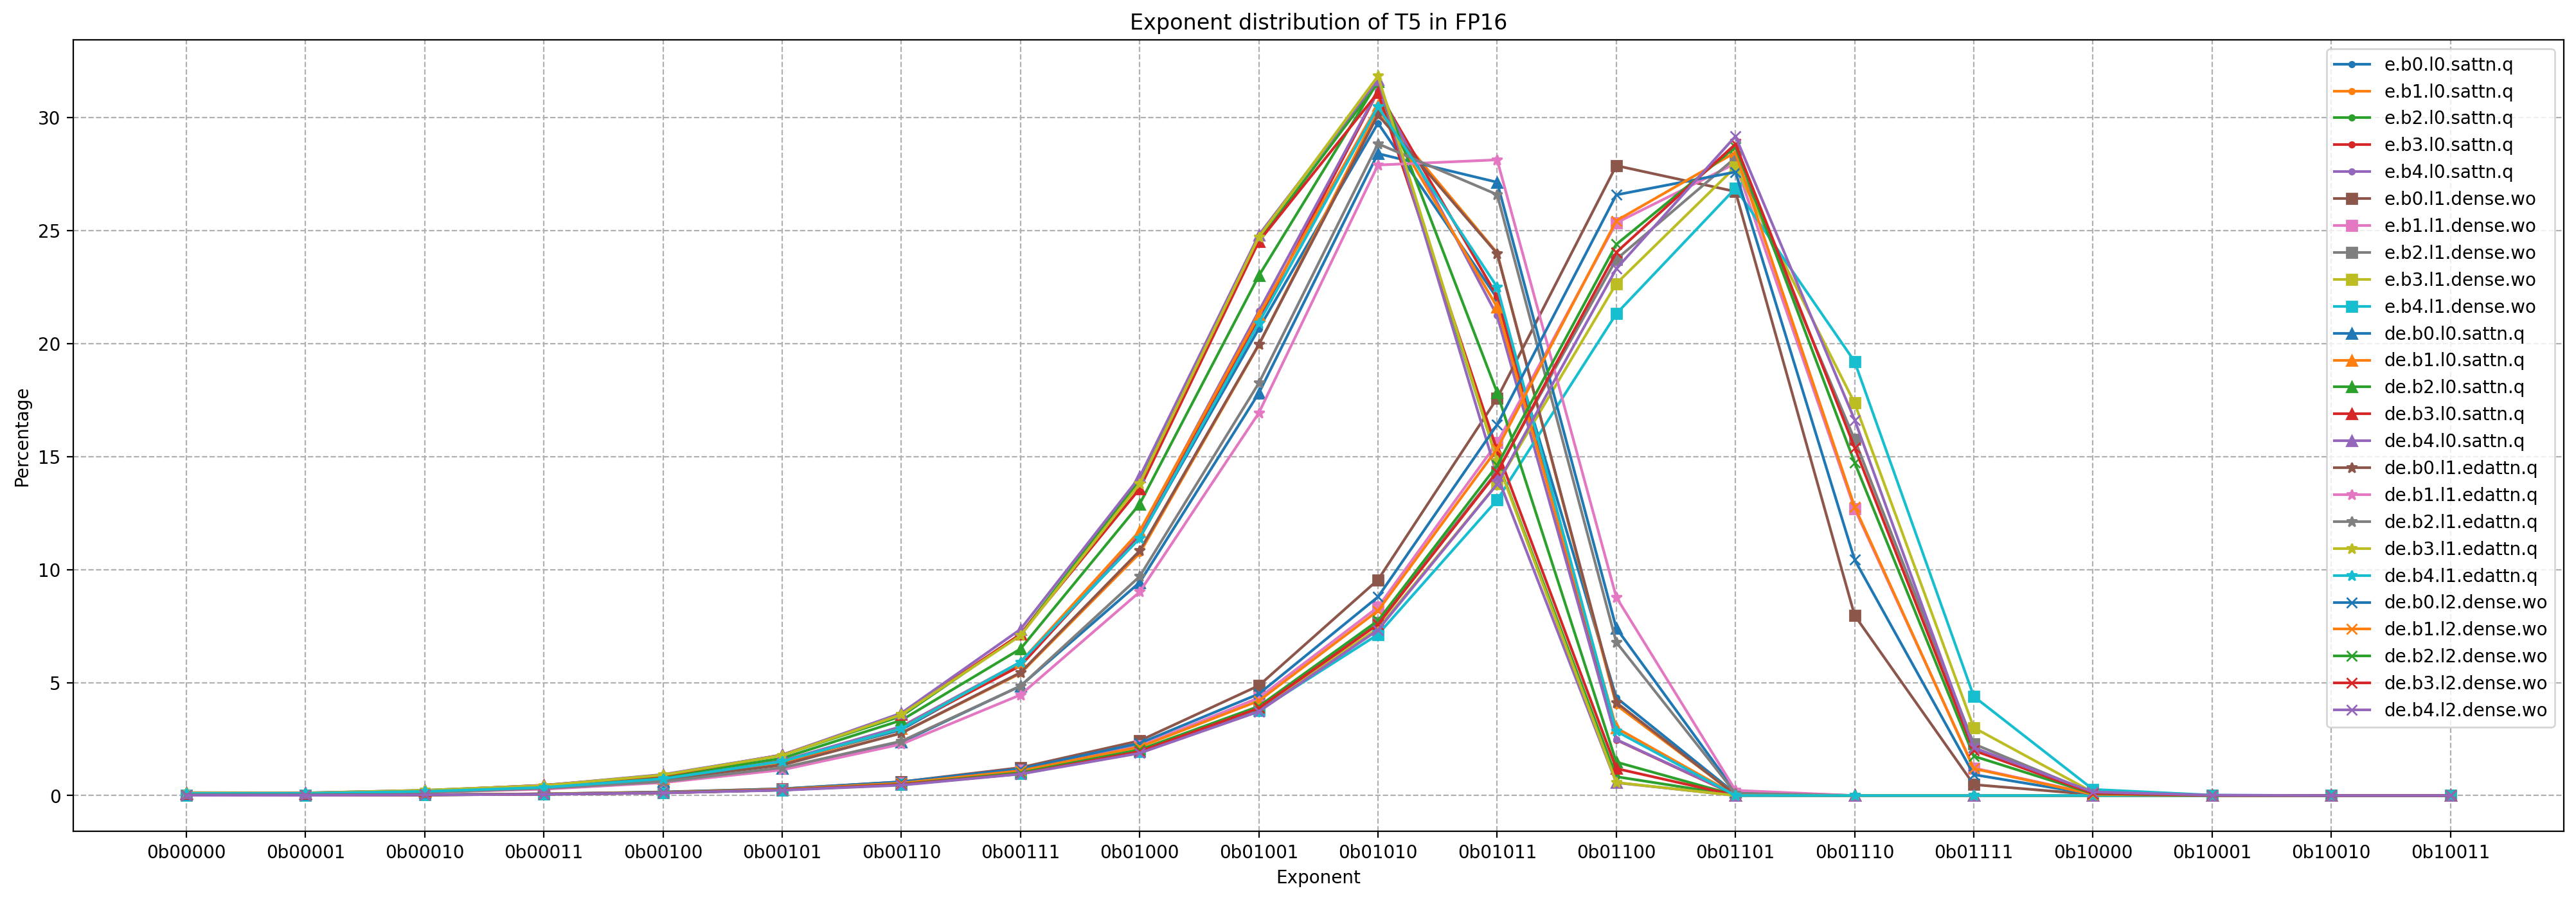

In [8]:
import matplotlib.pyplot as plt
import numpy as np

max_len = 0
for i in block:
    if len(torch.bincount(exponent[i].reshape(-1))) > max_len:
        max_len = len(torch.bincount(exponent[i].reshape(-1)))

bv = torch.zeros(len(block), max_len)
bc = lambda x: torch.bincount(x.reshape(-1))/torch.bincount(x.reshape(-1)).sum()

for i in range(len(block)):
    bv[i, :len(bc(exponent[block[i]]))] = bc(exponent[block[i]]) * 100

block_new = {}

for i, n in enumerate(block):
    name = ''
    n_l = n.split('.')
    if n_l[0] == 'encoder':
        name += 'e.'
    elif n_l[0] == 'decoder':
        name += 'de.'

    name += f"b{n_l[2]}.l{n_l[4]}."
    if n_l[5] == "SelfAttention":
        name += 'sattn.'
    elif n_l[5] == 'DenseReluDense':
        name += 'dense.'
    elif n_l[5] == 'EncDecAttention':
        name += 'edattn.'
    name += n_l[6]

    block_new[name] = bv[i]

xlabel = [format(i, "#07b") for i in range(20)]
plt.figure(figsize=(25, 8), dpi=200)
plt.grid(linestyle='--')
plt.title("Exponent distribution of T5 in FP16")
for k, v in block_new.items():
    if k[0] == 'e' and 'sattn' in k:
        m = '.'
    elif k[0] == 'e' and 'dense' in k:
        m = 's'
    elif k[0] == 'd' and 'sattn' in k:
        m = '^'
    elif k[0] == 'd' and 'edattn' in k:
        m = '*'
    elif k[0] == 'd' and 'dense' in k:
        m = 'x'
    plt.plot(xlabel, v, label=k, marker=m)
plt.legend()
plt.ylabel("Percentage")
plt.xlabel("Exponent")
plt.show()

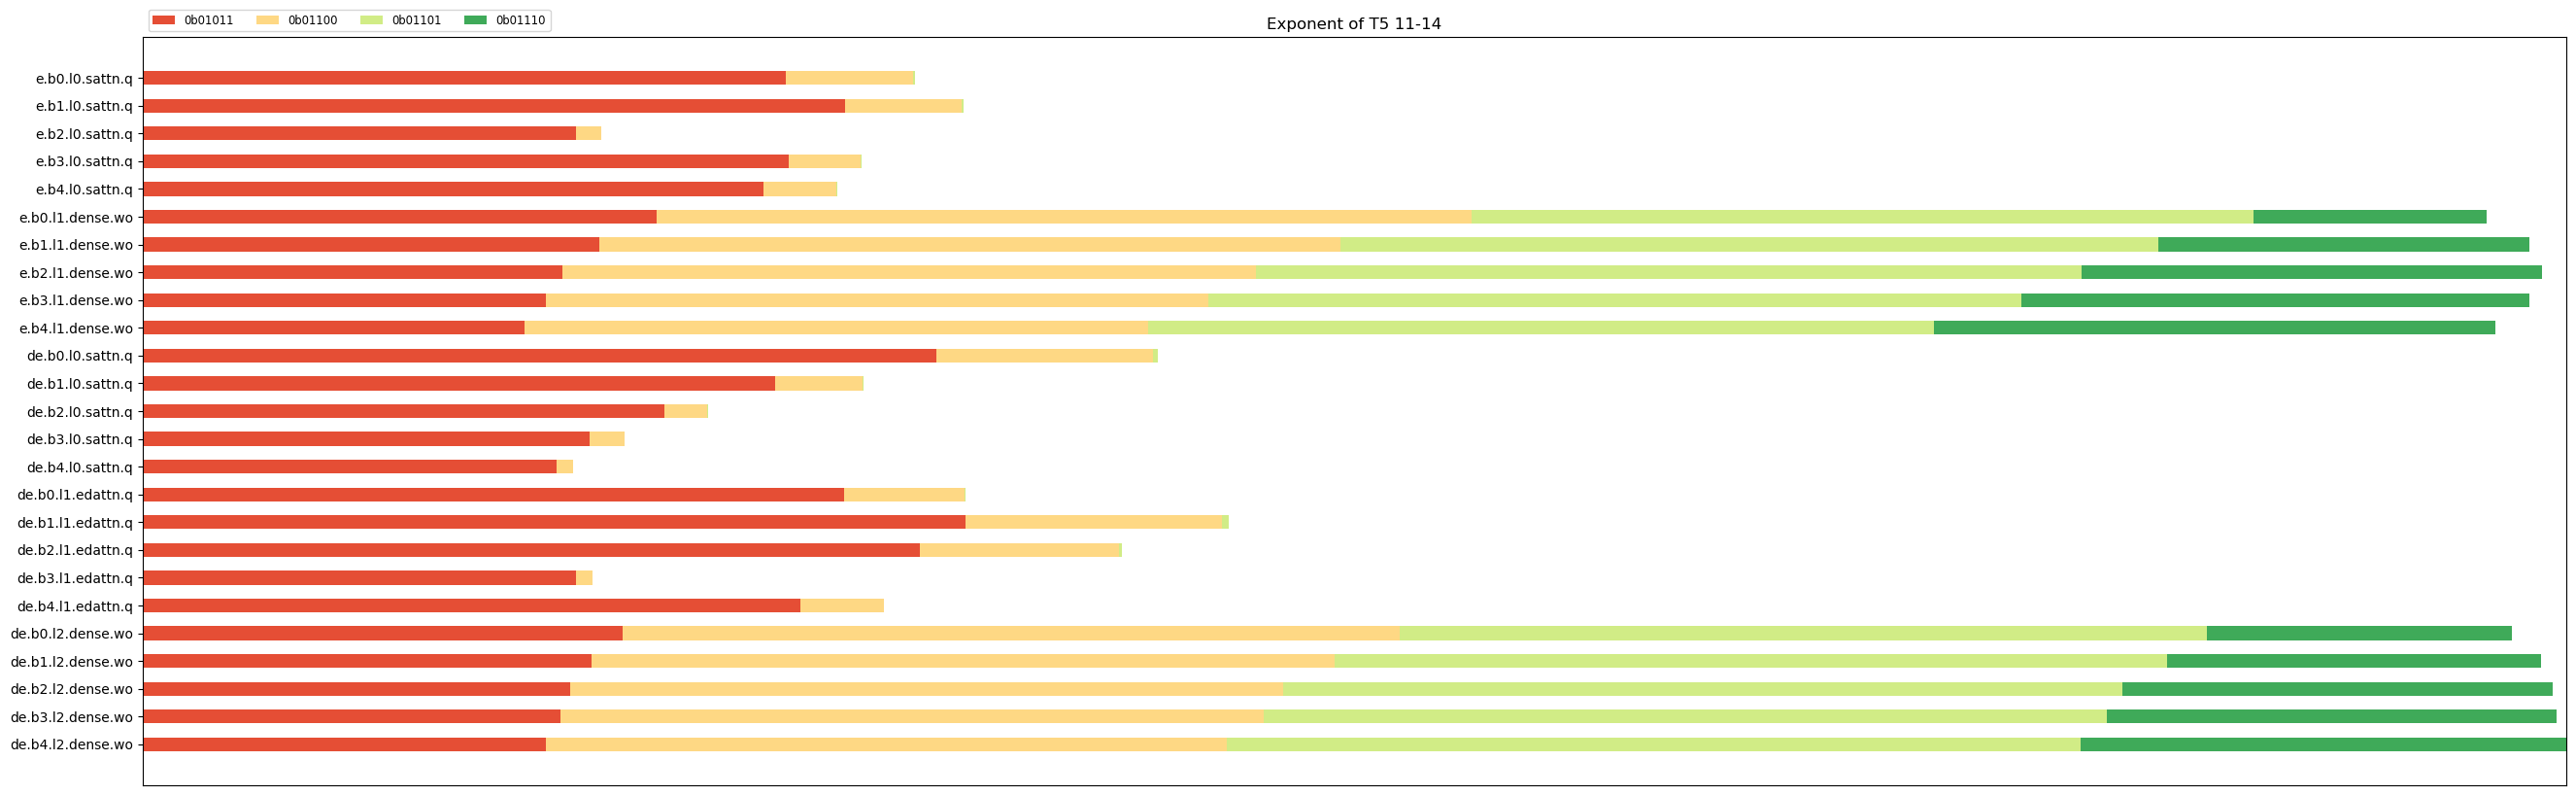

In [9]:
import matplotlib.pyplot as plt
import numpy as np

block_new = {}
s = 0b01011
e = 0b01111

for i, n in enumerate(block):
    name = ''
    n_l = n.split('.')
    if n_l[0] == 'encoder':
        name += 'e.'
    elif n_l[0] == 'decoder':
        name += 'de.'

    name += f"b{n_l[2]}.l{n_l[4]}."
    if n_l[5] == "SelfAttention":
        name += 'sattn.'
    elif n_l[5] == 'DenseReluDense':
        name += 'dense.'
    elif n_l[5] == 'EncDecAttention':
        name += 'edattn.'
    name += n_l[6]

    block_new[name] = bv[i, s: e]

category_names = [format(i, '#07b') for i in range(s, e)]
# results = {
#     'Question 1': [10, 15, 17, 32, 26],
#     'Question 2': [26, 22, 29, 10, 13],
#     'Question 3': [35, 37, 7, 2, 19],
#     'Question 4': [32, 11, 9, 15, 33],
#     'Question 5': [21, 29, 5, 5, 40],
#     'Question 6': [8, 19, 5, 30, 38]
# }

results = block_new

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2 * 3.5, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        # ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

survey(results, category_names)
plt.title("Exponent of T5 11-14")
plt.show()

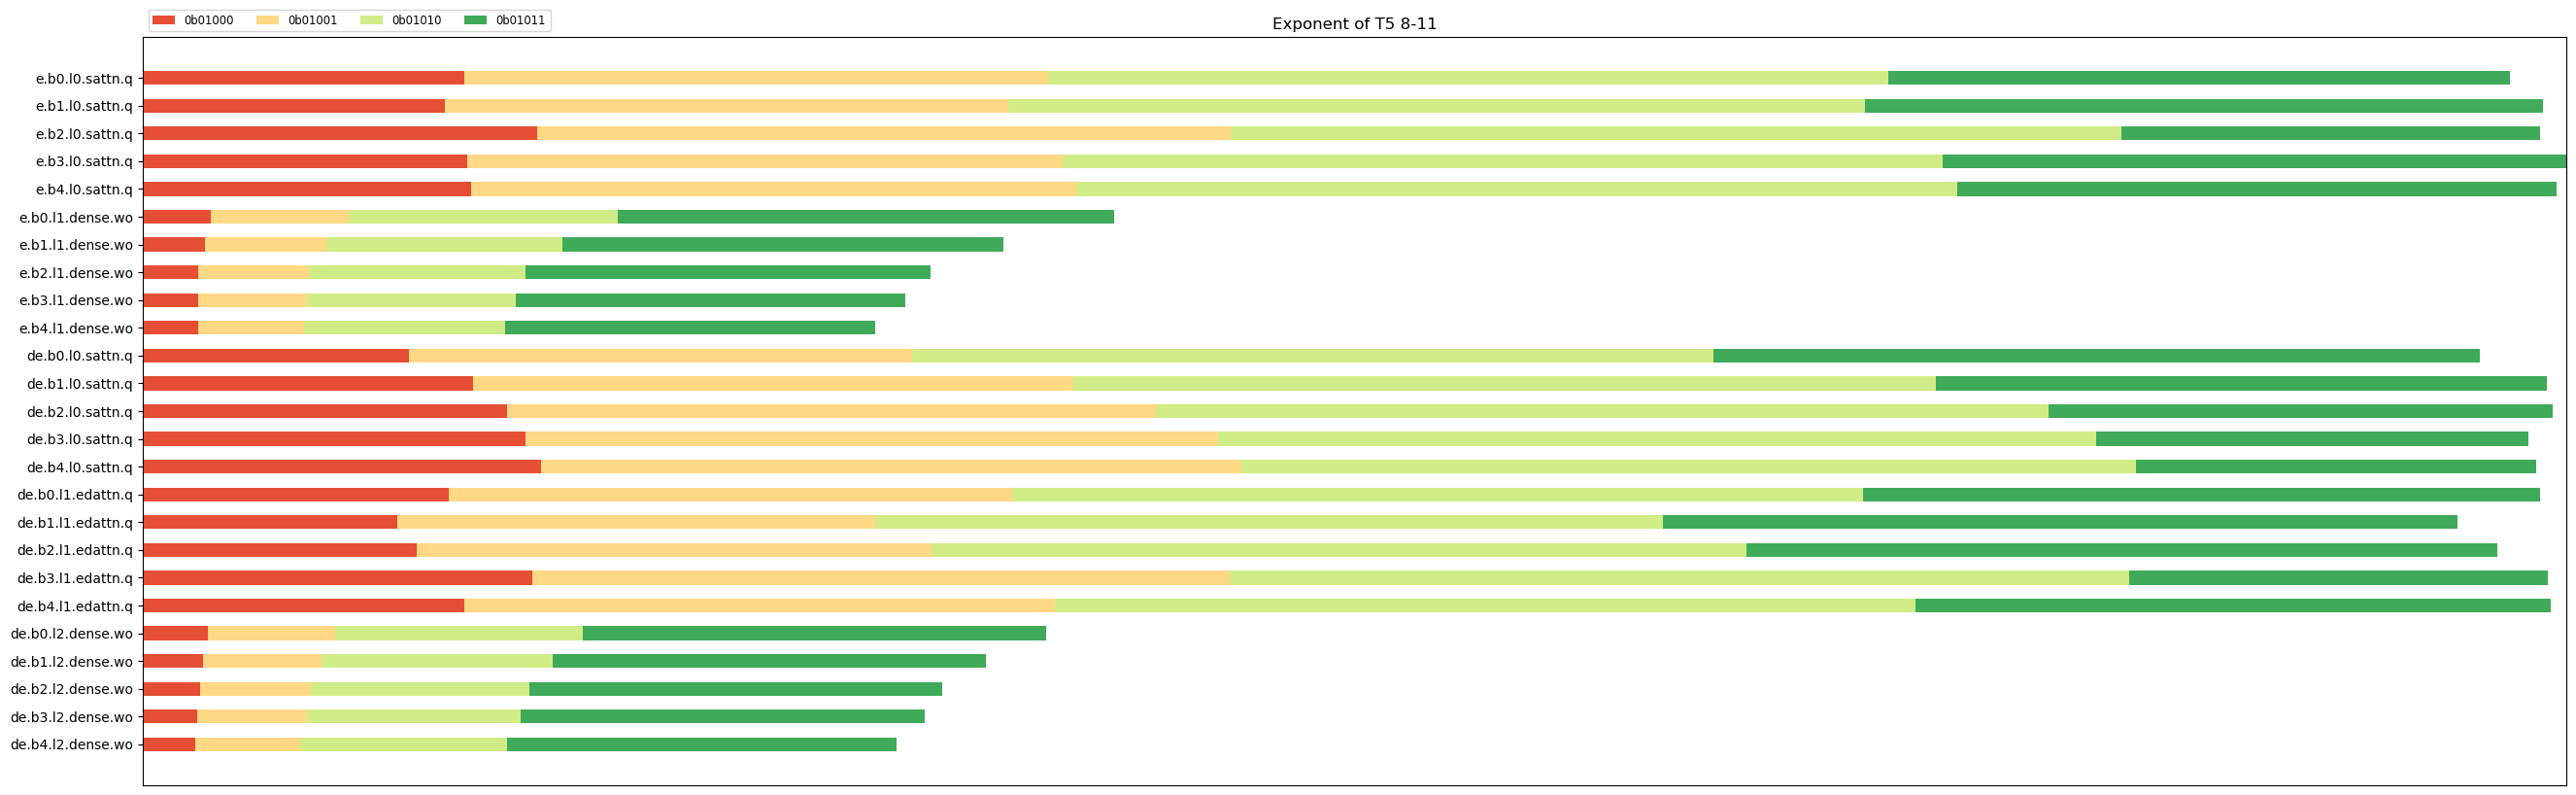

In [10]:
import matplotlib.pyplot as plt
import numpy as np

block_new = {}
s = 0b01000
e = 0b01100

for i, n in enumerate(block):
    name = ''
    n_l = n.split('.')
    if n_l[0] == 'encoder':
        name += 'e.'
    elif n_l[0] == 'decoder':
        name += 'de.'

    name += f"b{n_l[2]}.l{n_l[4]}."
    if n_l[5] == "SelfAttention":
        name += 'sattn.'
    elif n_l[5] == 'DenseReluDense':
        name += 'dense.'
    elif n_l[5] == 'EncDecAttention':
        name += 'edattn.'
    name += n_l[6]

    block_new[name] = bv[i, s: e]

category_names = [format(i, '#07b') for i in range(s, e)]
# results = {
#     'Question 1': [10, 15, 17, 32, 26],
#     'Question 2': [26, 22, 29, 10, 13],
#     'Question 3': [35, 37, 7, 2, 19],
#     'Question 4': [32, 11, 9, 15, 33],
#     'Question 5': [21, 29, 5, 5, 40],
#     'Question 6': [8, 19, 5, 30, 38]
# }

results = block_new

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2 * 3.5, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        # ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

survey(results, category_names)
plt.title("Exponent of T5 8-11")
plt.show()